In [1]:
%pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
!gdown "1Fs0PTy_xPsoX5bg4QTCrX6JAaQCHRzis"
!gdown "1JLa-ELhUskQINi0syf3YJWBX8jcCXdn4"

Downloading...
From: https://drive.google.com/uc?id=1Fs0PTy_xPsoX5bg4QTCrX6JAaQCHRzis
To: /kaggle/working/train.pkl
100%|███████████████████████████████████████| 4.09M/4.09M [00:00<00:00, 196MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JLa-ELhUskQINi0syf3YJWBX8jcCXdn4
To: /kaggle/working/test.pkl
100%|██████████████████████████████████████| 1.02M/1.02M [00:00<00:00, 95.2MB/s]


In [3]:
import pandas as pd
import nltk
import string
import re
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.isri import ISRIStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.svm import SVC
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from collections import OrderedDict
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.preprocessing import OneHotEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
label_to_class = {
    0: 'none',
    1: 'anger',
    2: 'joy',
    3: 'sadness',
    4: 'love',
    5: 'sympathy',
    6: 'surprise',
    7: 'fear'
}
classes = ['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear']

In [5]:
with open('/kaggle/working/train.pkl', 'rb') as f:
    train = pickle.load(f)

with open('/kaggle/working/test.pkl', 'rb') as f:
    test = pickle.load(f)

In [6]:
X_train = train['Light Stemming']
y_train = train['label']
X_test = test['Light Stemming']
y_test = test['label']

In [7]:
encoder = OneHotEncoder()

y_train = encoder.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_test = encoder.transform(y_test.values.reshape(-1,1)).toarray()

In [8]:
def prepare_tokenization(train, val, test=None, pad=500):
  tokenizer = Tokenizer(oov_token='<UNK>')
  tokenizer.fit_on_texts(train)
  tokenizer.word_index['<PAD>'] = 0
  train = tokenizer.texts_to_sequences(train)
  val = tokenizer.texts_to_sequences(val)
  if not pad==False:
    train = sequence.pad_sequences(train, maxlen=pad)
    val = sequence.pad_sequences(val, maxlen=pad)
  if not type(test)==type(None):
    test = tokenizer.texts_to_sequences(test)
    if not pad==False:
      test = sequence.pad_sequences(test, maxlen=pad)
  v_size = len(tokenizer.word_index)
  print("Vocabulary size={}".format(v_size))
  print("Number of Documents={}".format(tokenizer.document_count))
  if not type(test)==type(None):
    return v_size, train, val, test
  else:
    return v_size, train, val

In [9]:
VOCAB_SIZE, train_sequences, test_sequences = prepare_tokenization(X_train, X_test, pad=False)

Vocabulary size=22650
Number of Documents=8052


(array([5.460e+02, 1.762e+03, 1.954e+03, 1.314e+03, 1.684e+03, 7.210e+02,
        6.700e+01, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ]),
 <BarContainer object of 10 artists>)

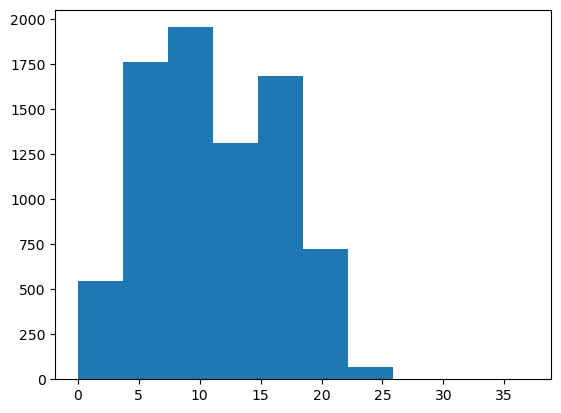

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
plt.hist(train_lens)

In [11]:
max_length = max(train_lens)

In [12]:
max_length

37

In [13]:
X_train = sequence.pad_sequences(train_sequences, maxlen=max_length)
X_test = sequence.pad_sequences(test_sequences, maxlen=max_length)
X_train.shape, X_test.shape

((8052, 37), (2013, 37))

In [14]:
BATCH_SIZE = 128
EPOCHS = 50
EMBED_SIZE = 300
LEARNING_RATE =  0.001

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True)

In [15]:
def create_gru_model(model_type):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=max_length, trainable=True))
    if model_type==1:
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True)))
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True)))
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=False)))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='softmax'))
    elif model_type==2:
        model.add(tf.keras.layers.GRU(512, return_sequences=True))
        model.add(tf.keras.layers.GRU(256, return_sequences=True))
        model.add(tf.keras.layers.GRU(128, return_sequences=False))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(8, activation='softmax'))
    elif model_type==3:
        model.add(tf.keras.layers.GRU(128, return_sequences=False))
        model.add(Dropout(0.5))
        model.add(Flatten())
        model.add(Dense(8, activation='softmax'))
    elif model_type==4:
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False)))
        model.add(Dropout(0.5))
        model.add(Flatten())
        model.add(Dense(8, activation='softmax'))
    elif model_type==5:
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=False)))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='softmax'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    # model.summary()

    history = model.fit(X_train, np.asarray(y_train), validation_data=(X_test, np.asarray(y_test)), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping_monitor])
    return model, history

In [16]:
for i in range(1,6):
    model, _ = create_gru_model(i)
    predictions = model.predict(X_test)
    print('--------------------------------------------------------')
    print()
    print('CLassification report for model {}: '.format(i))
    print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=classes))
    print()
    print('--------------------------------------------------------')

Epoch 1/50
63/63 [==============================] - 32s 273ms/step - loss: 1.9356 - accuracy: 0.2393 - val_loss: 1.6314 - val_accuracy: 0.3895
Epoch 2/50
63/63 [==============================] - 12s 186ms/step - loss: 1.4393 - accuracy: 0.4839 - val_loss: 1.2854 - val_accuracy: 0.5445
Epoch 3/50
63/63 [==============================] - 11s 169ms/step - loss: 1.0278 - accuracy: 0.6338 - val_loss: 1.2852 - val_accuracy: 0.5718
Epoch 4/50
63/63 [==============================] - 8s 129ms/step - loss: 0.7144 - accuracy: 0.7541 - val_loss: 1.4133 - val_accuracy: 0.5509
Epoch 5/50
63/63 [==============================] - 8s 125ms/step - loss: 0.4773 - accuracy: 0.8536 - val_loss: 1.5855 - val_accuracy: 0.5763
Epoch 6/50
63/63 [==============================] - 7s 111ms/step - loss: 0.3104 - accuracy: 0.9128 - val_loss: 1.8936 - val_accuracy: 0.5743
Epoch 7/50
63/63 [==============================] - 6s 98ms/step - loss: 0.2126 - accuracy: 0.9477 - val_loss: 2.0917 - val_accuracy: 0.5743
Epoc